In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library import QFT
import math
from matplotlib import pyplot as plt

# Add or subtract a register in QFT basis using controlled-phase gates
def _qft_add_register(qc, tgt, src, subtract=False):
    n, m = len(src), len(tgt)
    sign = -1 if subtract else 1
    for i in range(n):
        for j in range(i, m):
            angle = sign * 2 * math.pi / (2 ** (j - i + 1))
            qc.cp(angle, src[i], tgt[j])

# QFT comparator circuit: sets flag = 1 if x ≤ y
def qft_comparator_quantum(n: int):
    x = QuantumRegister(n, "x")
    y = QuantumRegister(n, "y")
    flag = QuantumRegister(1, "flag")
    qc = QuantumCircuit(x, y, flag, name="QFT_cmp_x_leq_y")

    ext = list(x) + [flag[0]]  # x + flag (flag = MSB)
    qc.append(QFT(len(ext), do_swaps=False), ext)
    _qft_add_register(qc, ext, y, subtract=True)
    qc.append(QFT(len(ext), do_swaps=False).inverse(), ext)

    qc.append(QFT(n, do_swaps=False), x)
    _qft_add_register(qc, x, y, subtract=False)
    qc.append(QFT(n, do_swaps=False).inverse(), x)

    # Flip flag to implement x ≤ y
    qc.x(flag[0])

    return qc.to_instruction(label="QFT_cmp_x_leq_y")

# Compare two values using a quantum circuit, return the full circuit
def compare_and_show_circuit(x_val: int, y_val: int) -> QuantumCircuit:
    if x_val < 0 or y_val < 0:
        raise ValueError("Only non-negative integers are supported")

    n = max(x_val.bit_length(), y_val.bit_length()) or 1
    cmp_gate = qft_comparator_quantum(n)

    xreg = QuantumRegister(n, "x")
    yreg = QuantumRegister(n, "y")
    flag = QuantumRegister(1, "flag")

    creg_x = ClassicalRegister(n, "cx")
    creg_y = ClassicalRegister(n, "cy")
    cflag  = ClassicalRegister(1, "cf")

    qc = QuantumCircuit(xreg, yreg, flag, creg_x, creg_y, cflag)

    # Load classical values into quantum registers
    for i in range(n):
        if (x_val >> i) & 1:
            qc.x(xreg[i])
        if (y_val >> i) & 1:
            qc.x(yreg[i])

    # Apply QFT-based comparator
    qc.append(cmp_gate, list(xreg) + list(yreg) + [flag[0]])

    # Measure everything
    qc.measure(xreg, creg_x)
    qc.measure(yreg, creg_y)
    qc.measure(flag, cflag)

    # Simulate
    backend = Aer.get_backend("aer_simulator")
    result = execute(qc, backend, shots=1).result().get_counts()
    outcome = list(result.items())[0][0].replace(" ", "")
    full_bits = outcome[::-1]  # MSB-first

    x_bits = full_bits[:n][::-1]
    y_bits = full_bits[n:2 * n][::-1]
    flag_bit = full_bits[-1]

    print("Quantum result:")
    print(f"  x = {x_val:>2} → bits = {x_bits}")
    print(f"  y = {y_val:>2} → bits = {y_bits}")
    print(f"  Flag (y ≤ x)   = {flag_bit}")
    print(f"\nDid  {y_val} ≤{x_val}? → {flag_bit == '1'}")

    return qc

# ▶️ Call and show circuit
qc = compare_and_show_circuit(14, 13)
qc.decompose(reps=10).draw(output='mpl')
plt.show()

C:\Users\km_ha\AppData\Local\Temp\ipykernel_17248\806337898.py:71: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, shots=1).result().get_counts()
c:\Users\km_ha\miniconda3\envs\oldqiskit\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


Quantum result:
  x = 14 → bits = 1110
  y = 13 → bits = 1101
  Flag (y ≤ x)   = 1

Did  13 ≤14? → True


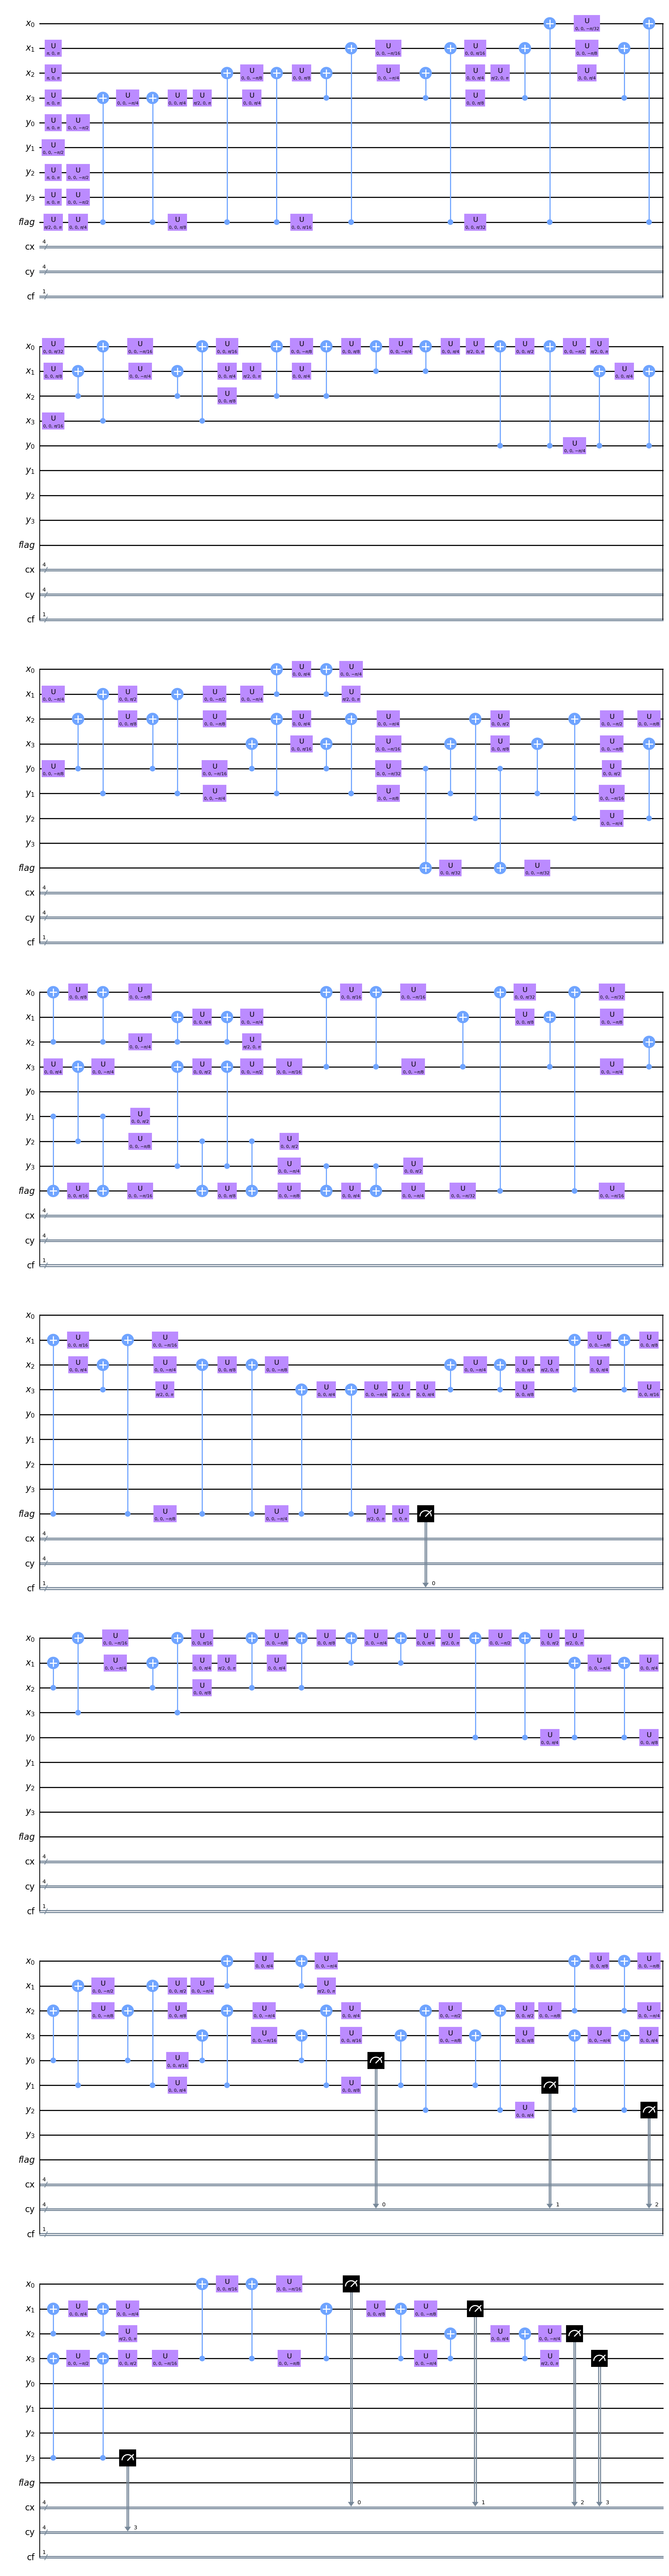

In [7]:
qc.decompose(reps=10).draw(output="mpl")
